<a href="https://colab.research.google.com/github/fboldt/aulasann/blob/main/aula04a_multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt

def plotDataset(X, y):
  plt.scatter(X[:,0], X[:,1], c=y)
  plt.xlim(0, 1)
  plt.ylim(0, 1)


In [2]:
def plotHiperplano(vector, intercept=0, dataset=None):
  xs = np.array([0, 1])
  ys = -(vector[0]*xs+intercept)/vector[1]
  plt.plot(xs, ys, 'r-')


In [3]:
import numpy as np
from sklearn.datasets import make_blobs

def criaDatasetMulticlasse(n=40, n_classes=4):
  X, y = make_blobs(n_samples=n, centers=n_classes, center_box=(0,1), cluster_std=0.02)
  return X, y

X, y = criaDatasetMulticlasse(n_classes=2)


In [4]:
X[:2, :], y[:2]

(array([[0.81811672, 0.90573977],
        [0.80548097, 0.87035451]]),
 array([0, 0]))

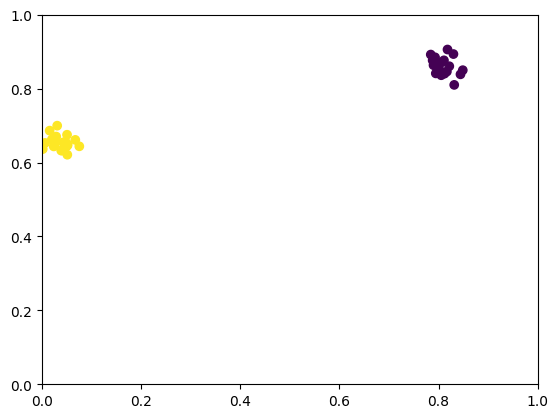

In [5]:
plotDataset(X, y)
plt.show()

In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score


In [7]:
def sign(a):
  return (a>=0)*2-1

In [8]:
from abc import ABC, abstractstaticmethod

class Cost(ABC):
  @abstractstaticmethod
  def getCost(y, ypred):
    pass
  @abstractstaticmethod
  def getGradient(y, ypred, X):
    pass

class WidrowHoff(Cost):
  @staticmethod
  def getCost(y, ypred):
    return np.sum((y-ypred)**2)
  @staticmethod
  def getGradient(y, ypred, X):
    return X.T @ (y-ypred)

class SmoothedSurrogate(Cost):
  @staticmethod
  def getCost(y, ypred):
    return np.sum(np.maximum(np.zeros(y.shape), -y * ypred))
  @staticmethod
  def getGradient(y, ypred, X):
    return X.T @ (y - sign(ypred))

class HingeLoss(Cost):
  @staticmethod
  def getCost(y, ypred):
    return np.sum(np.maximum(np.zeros(y.shape), 1-y*ypred))
  @staticmethod
  def getGradient(y, ypred, X):
    marginalserrors = (y * ypred) < 1
    marginal_ys = np.copy(y)
    marginal_ys[~marginalserrors] = 0
    return X.T @ marginal_ys

from scipy.special import expit

class LogLikelihood(Cost):
  @staticmethod
  def getCost(y, ypred):
    return np.sum(np.maximum(np.zeros(y.shape), 1 - y * ypred))
  @staticmethod
  def getGradient(y, ypred, X):
    return X.T @ (y - (expit(ypred)*2-1))

In [9]:
from abc import ABC, abstractmethod

class TrainingAlgorithm(ABC):
  @abstractmethod
  def getW(self, X, y):
    pass

class GradientDescent(TrainingAlgorithm):
  def __init__(self, max_iter=1000, learning_rate=0.001,
               regularization=0,
               cost=WidrowHoff()):
    self.max_iter = max_iter
    self.learning_rate = learning_rate
    self.regularization = regularization
    self.cost = cost

  def getW(self, X, y):
    w = np.random.uniform(-1, 1, size=(X.shape[1], y.shape[1]))
    for _ in range(self.max_iter):
      ypred = X @ w
      error = y - ypred
      w *= 1 - self.regularization * self.learning_rate
      w += self.cost.getGradient(y, ypred, X) * self.learning_rate
      if self.cost.getCost(y, ypred) == 0:
        break
    return w


[[ 0.58192706]
 [ 1.60574296]
 [-2.63545265]]
1.0


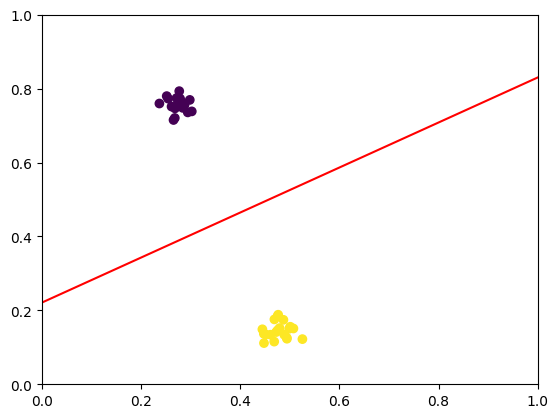

In [47]:
from sklearn.preprocessing import LabelBinarizer

def include_bias(X):
  bias = np.ones((X.shape[0],1))
  Xb = np.concatenate((bias, X), axis=1)
  return Xb

class NeuralNetwork(BaseEstimator, ClassifierMixin):
  def __init__(self, trainingAlgorithm=GradientDescent()):
    self.trainingAlgorithm = trainingAlgorithm

  def fit(self, X, y):
    self.labelBinarizer = LabelBinarizer()
    y = self.labelBinarizer.fit_transform(y)
    y = y * 2 - 1
    Xb = include_bias(X)
    self.w = self.trainingAlgorithm.getW(Xb, y)
    return self

  def predict(self, X):
    Xb = include_bias(X)
    ypred = Xb @ self.w
    if self.w.shape[1] == 1:
      ypred = sign(ypred)
    else:
      tmp = np.zeros(ypred.shape)
      idx = np.argmax(ypred, axis=1)
      tmp[np.arange(ypred.shape[0]), idx] = 1
      ypred = tmp
    ypred = self.labelBinarizer.inverse_transform(ypred)
    return ypred

model = NeuralNetwork(trainingAlgorithm=GradientDescent())
model.fit(X, y)
ypred = model.predict(X)
print(model.w)
print(accuracy_score(y, ypred))
plotDataset(X, y)
plotHiperplano(vector=model.w[1:], intercept=model.w[0])
plt.show()


In [ ]:
X, y = criaDatasetMulticlasse(n_classes=4)

[[ 0.10941194 -0.60287984  1.18426272 -2.16912863]
 [-1.88112943  1.71615488 -1.69014167  1.17525533]
 [ 1.09678316 -1.79466117 -1.01366793  1.61075117]]
1.0


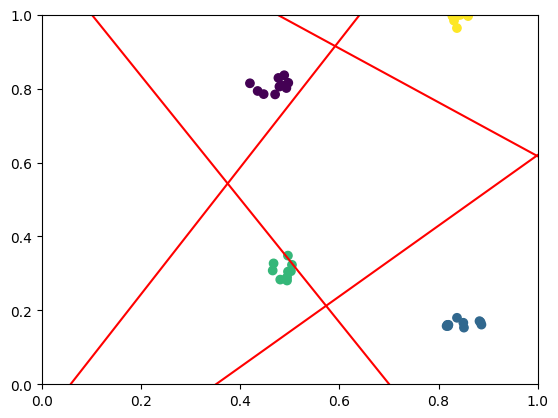

In [51]:
model = NeuralNetwork(trainingAlgorithm=GradientDescent())
model.fit(X, y)
ypred = model.predict(X)
print(model.w)
print(accuracy_score(y, ypred))
plotDataset(X, y)
for i in range(model.w.shape[1]):
  plotHiperplano(vector=model.w[1:,i], intercept=model.w[0,i])
plt.show()

In [ ]:
X, y = criaDatasetMulticlasse(n_classes=4)

[[-3.25328237  0.53949728  0.42866629 -2.02676684]
 [ 4.76838657 -1.10070858 -2.41711976 -2.08678557]
 [ 0.32116908 -2.60021221 -1.85239017  2.87907502]]
0.975


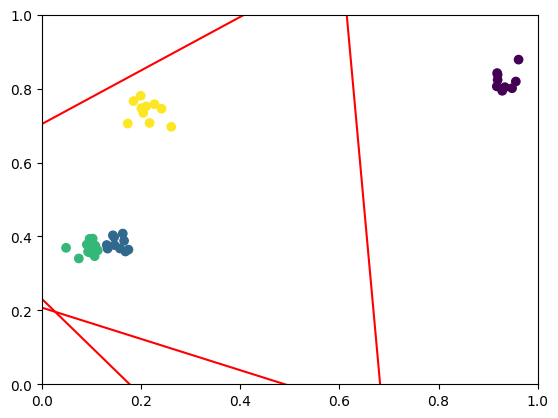

In [65]:
model = NeuralNetwork(trainingAlgorithm=GradientDescent(cost=LogLikelihood()))
model.fit(X, y)
ypred = model.predict(X)
print(model.w)
print(accuracy_score(y, ypred))
plotDataset(X, y)
for i in range(model.w.shape[1]):
  plotHiperplano(vector=model.w[1:,i], intercept=model.w[0,i])
plt.show()